# Project Evaluation Criteria

## Data Loading and Preprocessing (2 points max)
- Load the data from the CSV files using the appropriate data import methods in PyTorch.
- Apply dataset splits that enable you to assess network overfitting.
- Preprocess the categorical and numerical data accordingly (refer to **Lesson 5 – Training Practices and Regularization** and **Lesson 6 – PyTorch in Production**).
- Make data loading protocols for mini-batch training.

## Approach and Methodology (2 points max)
- Implement a neural network architecture suited to the task and justify your choice (refer to **Lesson 6 – PyTorch in Production**).
- Apply regularization techniques that help prevent network overfitting.

## Results and Evaluation (2 points max)
- Build a training protocol to train your neural network on the dataset with a user-specified number of epochs.
- Implement methods that effectively regulate the training process (refer to **Lab 5 – Training Practices and Regularization**).
- Provide visualizations, if useful, that give an indication of the training procedure (e.g., a loss curve). These visualizations can be included in your report as part of your submission package.
- Implement a software method that saves the network’s weight with the best performance.  
  - These network weights should be saved as `.pt` / `.pth` file.
  - Include them as part of your submission package so that the teacher and the teaching assistant can reproduce your results. 

## Code Quality and Reproducibility (2 points max)
- Your code should be clean, well-structured, and properly commented.
- Ensure the code runs in inference mode with your network weights (`.pt` / `.pth` file) to produce the target variable (the number of rings) using the data from `test.csv`.
- Ensure that the model generates predictions for the number of rings for every data point in the test set.
- Write a `README` file for running your code in inference mode to produce the targets.  
  - This will help the teacher and the teaching assistant reproduce your results. 

## Summary and Justification (2 points max)
- Clearly summarize the key novelties of your approach.
- Justify the choices made in the data preprocessing, neural network design, training protocol, and inference protocol.
- Discuss any challenges encountered and potential improvements.

## Importing the data

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

We will choose to use standardization because it includes the variance of the score. As we can see from the data ranges there may be outliers. And outliers may affect the the score a lot when we use the normalization route. We will only do this for the numerical columns and not the categorical column "Sex".

### Load and initiate the data

The files for creating the AbalonDataset and AbaloneNetwork are in their respective python files

In [4]:
from data_load import AbalonDataset
from model import AbaloneNetwork

train_dataset, test_dataset = AbalonDataset.create_train_test_val("train.csv")
val_dataset = AbalonDataset.create_train_test_val("test.csv", train_dataset)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loader = DataLoader(val_dataset, batch_size=batch_size)



Epoch 1/20, Train Loss: 9.4235, Val Loss: 9.2670
Saved Best Model
Epoch 2/20, Train Loss: 8.6444, Val Loss: 8.3640
Saved Best Model
Epoch 3/20, Train Loss: 7.5491, Val Loss: 7.0391
Saved Best Model
Epoch 4/20, Train Loss: 5.9595, Val Loss: 5.1734
Saved Best Model
Epoch 5/20, Train Loss: 3.9563, Val Loss: 3.1215
Saved Best Model
Epoch 6/20, Train Loss: 2.2788, Val Loss: 1.9776
Saved Best Model
Epoch 7/20, Train Loss: 1.7886, Val Loss: 1.8148
Saved Best Model
Epoch 8/20, Train Loss: 1.7349, Val Loss: 1.7856
Saved Best Model
Epoch 9/20, Train Loss: 1.7197, Val Loss: 1.7708
Saved Best Model
Epoch 10/20, Train Loss: 1.7092, Val Loss: 1.7602
Saved Best Model
Epoch 11/20, Train Loss: 1.7000, Val Loss: 1.7512
Saved Best Model
Epoch 12/20, Train Loss: 1.6912, Val Loss: 1.7425
Saved Best Model
Epoch 13/20, Train Loss: 1.6831, Val Loss: 1.7346
Saved Best Model
Epoch 14/20, Train Loss: 1.6753, Val Loss: 1.7273
Saved Best Model
Epoch 15/20, Train Loss: 1.6678, Val Loss: 1.7198
Saved Best Model
Epoc

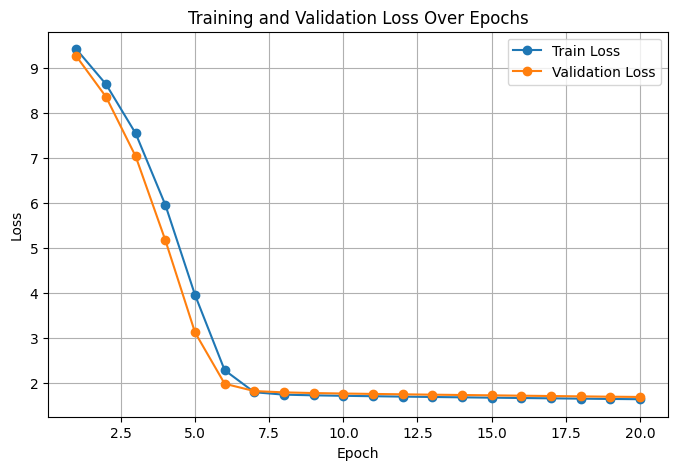

In [ ]:
def train_model(model, train_loader, optimizer, device, criterion, val_loader):
    model.train()
    train_loss = 0.0

    for inputs_load, targets_load in train_loader:
        inputs, targets = inputs_load.to(device), targets_load.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)  # Compute average train loss

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        

        
        val_loss /= len(val_loader)  # Compute average validation loss
    return train_loss, val_loss

def plot_figure(numepochs, trainlosses, vallosses):
    # Plot the loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, numepochs + 1), trainlosses, label="Train Loss", marker="o")
    plt.plot(range(1, numepochs + 1), vallosses, label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

num_epochs = 20
model = AbaloneNetwork(10, 10, 1)
device = torch.device("cpu")
model.to(device)
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=5e-3, weight_decay=1e-6)
best_val_loss = float("inf")

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs_load, targets_load in train_loader:
        inputs, targets = inputs_load.to(device), targets_load.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)  # Compute average train loss
    train_losses.append(train_loss)  # Store train loss

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        

        
        val_loss /= len(val_loader)  # Compute average validation loss
        val_losses.append(val_loss)  # Store validation loss



    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
    print("Saved Best Model")

plot_figure(num_epochs, train_losses, val_losses)


A mistake was made initially where the weight decay was set to 1e4 instead of 1e-4, this led to a frustrating debugging session. The loss values were NaN, and it was hard to find it out. After checking the first couple of loss values. We saw that the loss became increasing exponentially larger, until it was so large that NaN was displayed. This is a great example of exploding gradients. 

In [ ]:
class AbaloneNetwork(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_outputs))
    
    def forward(self, x):
        return self.model(x)


num_epochs = 10
model = AbaloneNetwork(10, 10, 1)
device = torch.device("cpu")
model.to(device)
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e5)
best_val_loss = float("inf")



In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_91265/1553115204.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_tensor = torch.tensor(row, dtype=torch.float32)


In [ ]:


# Validation phase
model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item()
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), "best_model.pth")
print("Saved Best Model")

/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_91265/1553115204.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_tensor = torch.tensor(row, dtype=torch.float32)


TypeError: unsupported operand type(s) for -: 'Tensor' and 'method'

In [ ]:
# Test phase
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")